# Pytorch Deep Neural Network V5
## Analysis of Gregor Dataset (Top Tagging)

## Uses preprocessed data

### 4 hidden layer NN
### Has real time plotting of training

## Started June, 6 2019
### Genevieve Hayes


In [26]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import seaborn as sb
import matplotlib.pylab as plt
#import matplotlib as mpl
import h5py
import tables
import math
import time
import sklearn.metrics as sklm

In [27]:
run_gpu=False
if run_gpu:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

In [28]:
#function to catch divisions by zero
def safe_div(x,y):
    division = np.empty(np.size(y))
    for idx in range(np.size(y)):
        if y[idx] == 0:
            division[idx] = x / 0.00001
        else:
            division[idx] = x / y[idx]       
    return division

#background_rejection = safe_div(1,fpr)

In [29]:
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split

# Training dataset loading class
class TrainDataset(Dataset):
    # Initialize our data, download, etc.  
    def __init__(self):
        #read pickle file
        df_train = pd.read_pickle("train.pkl")
        
        #numpy representation of DataFrame
        array_train = df_train.values
        
        self.len = array_train.shape[0]
        self.width = array_train.shape[1]
        self.x_data = torch.from_numpy(array_train[:,0:90]).float() #x data is only the 4 vectors of the constituents   
        self.y_data = torch.from_numpy(array_train[:,-1]).long() #y data is only the labels (0=QCD, 1=top)
        self.rawY_data = torch.from_numpy(array_train[:,-2]).long()
        self.weight = torch.from_numpy(array_train[:,0]).float()
        
    def __getitem__(self,index):
        return self.x_data[index],self.y_data[index], self.weight[index]
    
    def __len__(self):
        return self.len
    
# Validation dataset loading class
class ValDataset(Dataset):
    # Initialize our data, download, etc.
    def __init__(self):
        #read pickle file
        df_val = pd.read_pickle("val.pkl")
        
        #numpy representation of DataFrame
        array_val = df_val.values
        
        self.len = array_val.shape[0]
        self.width = array_val.shape[1]
        self.x_data = torch.from_numpy(array_val[:,0:90]).float()
        self.y_data = torch.from_numpy(array_val[:,-1]).long()
        self.rawY_data = torch.from_numpy(array_val[:,-2]).long()
        self.weight = torch.from_numpy(array_val[:,0]).float()
        
    def __getitem__(self,index):
        return self.x_data[index],self.y_data[index], self.weight[index]
    
    def __len__(self):
        return self.len

In [30]:
########################
# Load Preprocessed Data
########################
training_dataset = TrainDataset()
validation_dataset = ValDataset()

train_len = training_dataset.len
train_width = training_dataset.width
val_len = validation_dataset.len
val_width = validation_dataset.width

## Net Structure 

In [75]:
################################################
#Creating Network Structure class in PyTorch way
################################################
class Net(torch.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #Input layer is 30 constituents each with 3 features
        self.linear1 = nn.Linear(90,300) #4 hidden layers
        self.linear2 = nn.Linear(300,102)
        self.linear3 = nn.Linear(102,12)    
        self.linear4 = nn.Linear(12,6)
        self.linear5 = nn.Linear(6,2)  #1 output (top or qcd)
        
    def forward(self, x):
#        x = x.view(,-1) #Flatten the data
        out1 = F.relu(self.linear1(x))
        out2 = F.relu(self.linear2(out1))
        out3 = F.relu(self.linear3(out2))
        out4 = F.relu(self.linear4(out3))
        
        #y_pred = F.linear(self.linear5(out4),1)
        
        y_pred = out4
        
        #y_pred = F.softmax(self.linear5(out4),1) #softmax activation function
        #y_pred = torch.softmax(self.linear5(out4),1) #softmax activation function
        #y_pred = torch.sigmoid(self.linear5(out4)) #sigmoid activation function
        #y_preds.size() --> 5000, 2
        return y_pred
model = Net()

## Construct Loss and Optimizer

In [76]:
num_epochs = 8
#batch_len = 96
batch_len = 1000
learning_rate = 0.0001

In [77]:
######################
#Loss and optimization
######################
#criterion = torch.nn.BCELoss()
criterion = nn.CrossEntropyLoss()

#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5) #Stochastic Gradient Descent with momentum
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #ADAM optimizer

In [78]:
######################
#Make Dataloaders
######################
training_loader = DataLoader(dataset=training_dataset, batch_size=batch_len, shuffle=True, num_workers=2)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_len, shuffle=True, num_workers=2)

In [79]:
#####
#Trial 
#####
final_out = []
for i, data in enumerate(training_loader, 0):
        ### 1. get the inputs ###
        inputs,labels,_=data
        ### 2. wrap them in Variable ###
        inputs, labels = Variable(inputs), Variable(labels)
        inputs, labels = inputs.to(device), labels.to(device)
        #Forward pass: Compute predicted y by passing x to the model
        outputs=model(inputs)
        preds=torch.max(outputs.data,1)[1]
        final_out.extend(preds)
        #preds has size [batch_size]
        
#check size and shape of labels, inputs, outputs

print(labels.shape)    #= torch.Size([500])
#print(inputs.shape)    #= torch.Size([500, 800])
print(outputs.data.shape)   #= torch.Size([500, 2])
#print(len(final_out))  #= 1211000

torch.Size([1000])
torch.Size([1000, 6])


In [80]:
print(outputs.data[-40:-1])

tensor([[1.0862e-02, 2.0671e-01, 1.0043e-01, 0.0000e+00, 2.4306e-01, 6.7649e-02],
        [4.0233e-04, 2.0323e-01, 1.2090e-01, 0.0000e+00, 2.4392e-01, 7.3919e-02],
        [0.0000e+00, 1.9904e-01, 1.2278e-01, 0.0000e+00, 2.4060e-01, 7.4808e-02],
        [2.9182e-03, 2.0415e-01, 1.2129e-01, 0.0000e+00, 2.4748e-01, 7.5438e-02],
        [0.0000e+00, 1.9643e-01, 1.2147e-01, 0.0000e+00, 2.4209e-01, 7.6721e-02],
        [0.0000e+00, 1.9064e-01, 1.2785e-01, 0.0000e+00, 2.3841e-01, 8.0048e-02],
        [0.0000e+00, 1.9506e-01, 1.2488e-01, 0.0000e+00, 2.3992e-01, 7.7445e-02],
        [0.0000e+00, 1.9835e-01, 1.2410e-01, 0.0000e+00, 2.3980e-01, 7.6240e-02],
        [3.6924e-03, 2.0140e-01, 1.2101e-01, 0.0000e+00, 2.4658e-01, 7.7692e-02],
        [0.0000e+00, 1.8954e-01, 1.2845e-01, 0.0000e+00, 2.3830e-01, 8.0673e-02],
        [4.6747e-03, 2.0360e-01, 1.2281e-01, 0.0000e+00, 2.3768e-01, 7.3494e-02],
        [1.4406e-03, 2.0703e-01, 1.1987e-01, 0.0000e+00, 2.4049e-01, 7.0503e-02],
        [0.0000e

## Train the neural network

Epoch 0/7
--
Training Accuracy:0.6952
Validation Accuracy:0.8149 



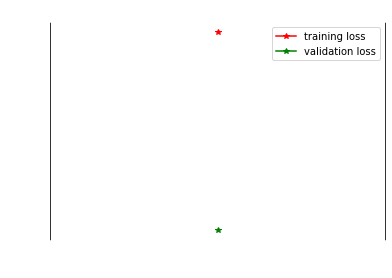

Epoch 1/7
--
Training Accuracy:0.8419
Validation Accuracy:0.8642 

Epoch 2/7
--
Training Accuracy:0.8734
Validation Accuracy:0.8783 



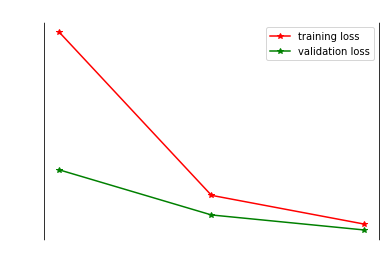

Epoch 3/7
--
Training Accuracy:0.8822
Validation Accuracy:0.8836 

Epoch 4/7
--
Training Accuracy:0.8863
Validation Accuracy:0.8867 



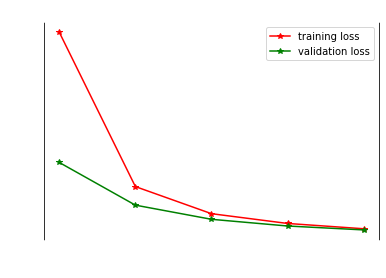

Epoch 5/7
--
Training Accuracy:0.8887
Validation Accuracy:0.8889 

Epoch 6/7
--
Training Accuracy:0.8906
Validation Accuracy:0.8902 



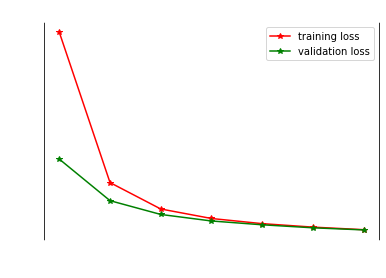

Epoch 7/7
--
Training Accuracy:0.8918
Validation Accuracy:0.8910 



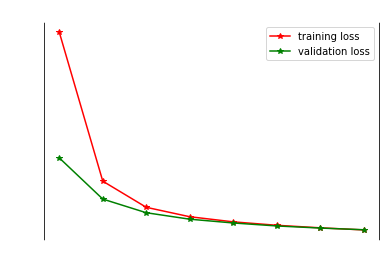

--- 143.27351999282837 seconds ---
--- 2 min and 24 sec ---


In [81]:
#########
#Training
#########
start_time = time.time()

training_loss_list=[]
validation_loss_list=[]
training_acc_list=[]
validation_acc_list = []

for epoch in range(num_epochs):
#Training cycle (forward, backward, update)
    if (epoch%1==0 or epoch==num_epochs - 1):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))
        print('-' * 2)
        
    model.train()
    train_loss = 0.0
    train_corrects = 0
    
    for i, data in enumerate(training_loader, 0):
        
        ### 1. get the inputs ###
        inputs,labels,_=data
        
        ### 2. wrap them in Variable ###
        inputs, labels = Variable(inputs), Variable(labels)
        inputs, labels = inputs.to(device), labels.to(device)
        
        
        #Forward pass: Compute predicted y by passing x to the model
        outputs=model(inputs)
        preds=torch.max(outputs.data,1)[1]
        
        #print(labels.size())
        #print(outputs.size())
        #outputs = outputs[:,0]
        #print(labels.size())
        #print(outputs.size())
        
        #Compute loss
        loss=criterion(outputs,labels)
        #loss=criterion(outputs.float(),labels.float())
        #loss=criterion(outputs.long(),labels.long())
        
        #Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*inputs.size(0)
        
        #extract TP+TN
        train_corrects += torch.sum(preds == labels.data)
        
    epocht_loss = train_loss/train_len
    epocht_acc = train_corrects.double()/train_len

    training_loss_list.append(epocht_loss)
    training_acc_list.append(epocht_acc)
    
    #Visualization
    print('Training Accuracy:{:.4f}'.format(epocht_acc))
    if (epoch%2==0 or epoch==num_epochs - 1):
    
        counter = range(epoch+1)
        figtrain = plt.figure()
        axtrain = figtrain.add_subplot(111)
        plt.plot(counter,training_loss_list,'-*r',linestyle = 'solid',label="training loss")
#Validation cycle (forward, save)
    model.eval()
    val_loss=0
    val_corrects=0
    final_output = []
    final_preds = []
    final_weights = []
    final_labels = []
    
    with torch.no_grad():
        for data in validation_loader:
            inputs,labels,weights=data
            inputs,labels = Variable(inputs), Variable(labels)
            outputs = model(inputs)
            weight_list=weights.numpy()
            #sum up batch loss
            loss = criterion(outputs,labels)
            #loss = criterion(outputs.float(),labels.float())
            #loss=criterion(outputs.long(),labels.long())
            #get the index of the max log-probability
            preds=torch.max(outputs.data,1)[1]
            val_loss += loss.item()*inputs.size(0)
            
            #extract TP+TN
            val_corrects += torch.sum(preds == labels.data)
            
            final_preds.extend(preds.data.numpy())
            final_output.extend(outputs[:,1].data.numpy())
            #final_output.extend(outputs.data.numpy())
            final_weights.extend(weight_list)
            final_labels.extend(labels.data.numpy())
        
        epoch_loss = val_loss / val_len
        epoch_acc = val_corrects.double() / val_len
        
        validation_loss_list.append(epoch_loss)
        validation_acc_list.append(epoch_acc)

        #Visualization
        print('Validation Accuracy:{:.4f} \n'.format(epoch_acc))
        if (epoch%2==0 or epoch==num_epochs - 1):
            counter = range(epoch+1)
            plt.plot(counter,validation_loss_list,'-*g',linestyle = 'solid',label="validation loss")
        
            plt.title('Loss as a function of epoch',color='w')
            plt.xlabel('Epoch',color='w')
            plt.ylabel('Loss',color='w')
            axtrain.spines['bottom'].set_color('white')
            axtrain.spines['top'].set_color('white')
            axtrain.tick_params(axis='x', colors='white')
            axtrain.tick_params(axis='y', colors='white')
            plt.legend(loc='upper right')
            plt.show()
  
end_time = time.time()   
print("--- {} seconds ---".format(end_time-start_time)) 
print("--- {} min and {} sec ---".format(math.floor((end_time-start_time)/60),math.ceil((end_time-start_time)%60)))

## Evaluate model based on validation data and training data

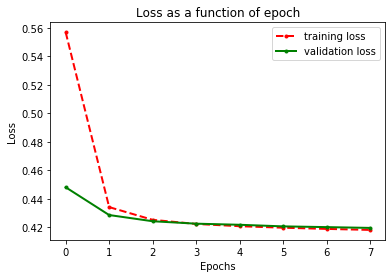

-----8 epochs-----
 
Validation Accuracy: 0.8925
Validation Accuracy:0.8907


In [57]:
x=range(num_epochs)
y_train=training_loss_list
y_val = validation_loss_list
#y_test=testing_loss_list

fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.plot(x,y_train,marker='o',markersize=3,linewidth=2,linestyle='dashed',color='r',label="training loss")
plt.plot(x,y_val,marker='o',markersize=3,linewidth=2,linestyle = 'solid', color='g',label="validation loss")
#plt.plot(x,y_test,marker='o',markersize=3,linewidth=2,linestyle='dashed',color='b',label="test loss")
plt.title('Loss as a function of epoch')#,color='w')

#ax1.spines['bottom'].set_color('white')
#ax1.spines['top'].set_color('white')
#ax1.xaxis.label.set_color('white')
#ax1.yaxis.label.set_color('white')
#ax1.tick_params(axis='x', colors='white')
#ax1.tick_params(axis='y', colors='white')

ax1.set_xlabel('Epochs')#, color='white')
ax1.set_ylabel('Loss')#, color='white')

plt.legend(loc='upper right')
plt.legend()
plt.show()

print('-----{:d} epochs-----\n \nValidation Accuracy: {:.4f}'.format(num_epochs,training_acc_list[-1]))
print('Validation Accuracy:{:.4f}'.format(validation_acc_list[-1]))#epocht_acc))

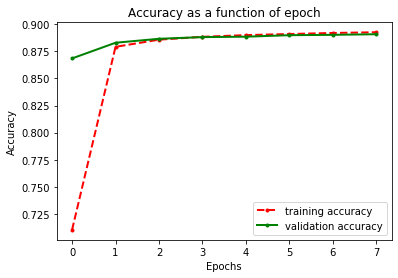

In [58]:
x=range(num_epochs)
y_train=training_acc_list
y_val = validation_acc_list

fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111)

plt.plot(x,y_train,marker='o',markersize=3,linewidth=2,linestyle='dashed',color='r',label="training accuracy")
plt.plot(x,y_val,marker='o',markersize=3,linewidth=2,linestyle = 'solid', color='g',label="validation accuracy")
#plt.plot(x,y_test,marker='o',markersize=3,linewidth=2,linestyle='dashed',color='b',label="test accuracy")
plt.title('Accuracy as a function of epoch')#,color='w')

ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

plt.legend(loc='upper right')
plt.legend()
plt.show()

# Validation Confusion Matrix

In [59]:
val_outputs = np.array(final_output)
val_predicted = np.array(final_preds)
#val_truth = validation_dataset.y_data.numpy()
val_truth = np.array(final_labels)

validation_confusion_matrix = sklm.confusion_matrix(val_truth,val_predicted)
tn, fp, fn, tp = sklm.confusion_matrix(val_truth,val_predicted).ravel()

print('TN = {}, FP = {}, FN = {}, TP = {}\n'.format(tn, fp, fn, tp))
print('Confusion matrix of validation data:\n',validation_confusion_matrix)

TN = 167488, FP = 34015, FN = 10025, TP = 191472

Confusion matrix of validation data:
 [[167488  34015]
 [ 10025 191472]]


[9.9998164e-01 1.0000000e+00 9.9957412e-01 1.9647767e-04 9.9999702e-01
 1.0000000e+00 1.0000000e+00 9.8043847e-01 9.9918252e-01 1.0000000e+00
 1.0000000e+00 9.9999952e-01 1.0000000e+00 9.9996996e-01 1.0000000e+00
 9.9998879e-01 9.9999976e-01 9.7600740e-01 9.9999833e-01 9.9999917e-01
 1.0000000e+00 9.9999845e-01 9.9999976e-01 9.8707050e-01 9.9999070e-01
 9.9314064e-01 9.9903047e-01 9.9989891e-01 9.9999964e-01 9.9965250e-01
 9.9999690e-01 9.9932587e-01 9.9998057e-01 9.9999857e-01 9.9704617e-01
 1.0000000e+00 9.9996042e-01 1.0000000e+00 2.5950119e-04 9.9999976e-01
 9.9999571e-01 7.5511366e-02 9.9999797e-01 9.9829537e-01 9.9984372e-01
 9.9999928e-01 9.9999833e-01 1.0000000e+00 9.9999964e-01 9.9998629e-01]
[0.058233563, 0.1480384, 0.15886153, 0.048306998, 0.05839542, 0.07681869, 0.12721147, 0.1460855, 0.053167008]


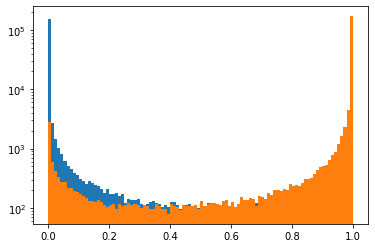

In [60]:
#observing the background and signal distributions
top_scores = val_outputs[val_truth==1]
background_scores = val_outputs[val_truth==0]

plt.hist(background_scores,bins=100,log=True)
plt.hist(top_scores,bins=100, log=True)
print(top_scores[0:50])

print(final_weights[-10:-1])

# Precision, Recall and F-measure

In [61]:
precision = sklm.precision_score(val_truth,val_predicted)
#print('Precision: {:.4f}'.format(precision))
recall = sklm.recall_score(val_truth,val_predicted)
#print('Recall: {:.4f}'.format(recall))
f1 = sklm.f1_score(val_truth,val_predicted)
#print('F1: {:.4f}'.format(f1))

from IPython.display import HTML, display
import tabulate
table = [["Precision","{:.3f}".format(precision)],
         ["Recall","{:.3f}".format(recall)],
         ["F1","{:.3f}".format(f1)]]
        
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Precision,0.849
Recall,0.95
F1,0.897


# Validation ROC Curve and AUC

In [63]:
#plt.hist(outputs.data[:,0])
#plt.hist(final_output)
#plt.hist(preds.data[:])
#print(preds.shape)
#print(outputs.data)

#print(len(outputs.data))
#print(len(final_output))
#print(len(validation_dataset.y_data))

print(np.array(final_output[0:20]))
print(np.transpose(validation_dataset.y_data[0:20].numpy()))

[1.3226426e-04 2.8860641e-05 9.9998164e-01 1.0000000e+00 4.9978782e-05
 4.5868978e-03 2.8277721e-04 9.9957412e-01 1.9647767e-04 2.6735368e-06
 2.5316015e-07 7.5756951e-05 1.1603736e-01 9.9999702e-01 2.0397119e-05
 3.4584944e-05 1.0000000e+00 1.7432229e-05 9.9999940e-01 1.0000000e+00]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


AUC: 0.9216


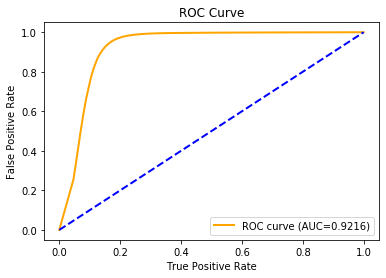

In [64]:
##############################
#Standard Validation ROC Curve
##############################
fpr, tpr, thresholds = sklm.roc_curve(val_truth,val_outputs,pos_label=1)
auc = sklm.roc_auc_score(val_truth,val_outputs)

print('AUC: {:.4f}'.format(auc))

#ROC curve
fig3 = plt.figure(3)
ax3 = fig3.add_subplot(111)

#plt.plot(fpr,tpr)
#false positive x, true positive y
plt.plot(fpr,tpr,linewidth=2,linestyle='solid',color='orange',label="ROC curve (AUC={:.4f})".format(auc))
plt.plot(fpr,fpr,linewidth=2,linestyle='dashed',color='b')
plt.title('ROC Curve')

ax3.set_xlabel('True Positive Rate')
ax3.set_ylabel('False Positive Rate')

plt.legend(loc='lower right')
plt.legend()
plt.show()

In [65]:
print(tpr[:50])
print(fpr[:50])

[0.         0.25479288 0.30253056 0.32665002 0.34328551 0.35600034
 0.36607989 0.37497332 0.38231338 0.38848717 0.39474533 0.40002581
 0.40490925 0.40941552 0.41347514 0.41691936 0.42059187 0.42375817
 0.42705847 0.43009573 0.43286997 0.43566902 0.43829437 0.44074602
 0.44316789 0.44546569 0.44775356 0.45006129 0.45204643 0.45408617
 0.4560316  0.45789764 0.45974878 0.46144111 0.46299449 0.46448334
 0.46617071 0.46766453 0.46902932 0.47072165 0.47215095 0.47367455
 0.47513362 0.47644878 0.47789793 0.47924287 0.48071683 0.48200221
 0.48328263 0.48442409]
[0.         0.04645588 0.0513243  0.05367662 0.05518032 0.05631678
 0.05734902 0.05819764 0.05887754 0.05950284 0.06006362 0.06063433
 0.0610115  0.06144325 0.06189982 0.0623018  0.06265912 0.06297673
 0.06319509 0.06354248 0.0638452  0.06408341 0.06434644 0.06453502
 0.06471368 0.06498166 0.06520498 0.06546801 0.06561193 0.06579555
 0.06594939 0.06612805 0.066267   0.06644566 0.06662928 0.06675831
 0.06693201 0.06708585 0.06720495 0.06

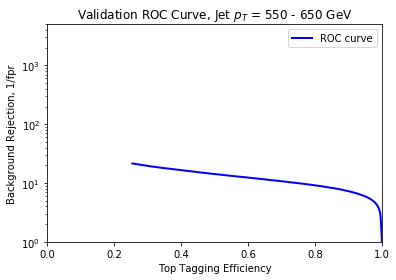

47141
47141


In [66]:
##########################
#Log Validation ROC Curve
#########################
background_rejection = safe_div(1,fpr)
#background_rejection = 1/fpr[1:] #the first and second elements of fpr are usually zero, so disregard these to avoid divide by zero

#ROC curve (using background rejection)
fig4 = plt.figure(4)
ax4 = fig4.add_subplot(111)

#plt.plot(fpr,tpr)
plt.semilogy(tpr[1:],background_rejection[1:],linewidth=2,linestyle='solid',color='blue',label="ROC curve")
#plt.plot(background_rejection,background_rejection,linewidth=2,linestyle='dashed',color='b')
plt.title('Validation ROC Curve, Jet $p_T$ = 550 - 650 GeV')#,color='w')

ax4.set_xlabel('Top Tagging Efficiency')#, color='white')
ax4.set_ylabel('Background Rejection, 1/fpr')#, color='white')
plt.ylim(1, 5000)
plt.xlim(0,1)

plt.legend(loc='upper right')
plt.legend()
plt.show()

print(len(fpr))
print(len(tpr))

In [67]:
#find the % closest to the % signal efficiency of interest
def find_nearest_ind(array,value):
    array = np.asarray(array)
    ind = (np.abs(array-value)).argmin()
    return ind, array[ind]

In [68]:
#####################
#Background Rejection
#####################
#looking at 20%, 50% and 80% signal efficiency
index_20,signal_efficiency_20 =find_nearest_ind(tpr,0.2)
index_50,signal_efficiency_50 =find_nearest_ind(tpr,0.5)
index_80,signal_efficiency_80 =find_nearest_ind(tpr,0.8)

#print('Background rejection at {:.1f}% signal efficiency: {:.3}\n'.format(signal_efficiency_20*100,background_rejection[index_20]))
#print('Background rejection at {:.1f}% signal efficiency: {:.3}\n'.format(signal_efficiency_50*100,background_rejection[index_50]))
#print('Background rejection at {:.1f}% signal efficiency: {:.3}\n'.format(signal_efficiency_80*100,background_rejection[index_80]))

from IPython.display import HTML, display
import tabulate
table = [["Signal Efficiency","Background Rejection"],
         ["{:.1f}".format(signal_efficiency_20*100),"{:.2f}".format(background_rejection[index_20])],
         ["{:.1f}".format(signal_efficiency_50*100),"{:.2f}".format(background_rejection[index_50])],
         ["{:.1f}".format(signal_efficiency_80*100),"{:.2f}".format(background_rejection[index_80])]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Signal Efficiency,Background Rejection
25.5,21.53
50.0,14.20
80.0,9.13


In [69]:
#Would like a DNN distribution for the signal and background samples (probability density as a function of neural network output)
#plt.plot(outputs.data[:,1])
#print(outputs.data[:,1])

# Results: Testing the Neural Network

In [70]:
###############################
#Testing dataset loading class
##############################
class TestDataset(Dataset):
    # Initialize our data, download, etc.
    def __init__(self):
        #read pickle file
        df_test = pd.read_pickle("test.pkl")
        
        #numpy representation of DataFrame
        array_test = df_test.values
        
        self.len = array_test.shape[0]
        self.width = array_test.shape[1]
        self.x_data = torch.from_numpy(array_test[:,0:90]).float()
        self.y_data = torch.from_numpy(array_test[:,-1]).long()
        #self.rawY_data = torch.from_numpy(array_test[:,-2]).long()
        #self.weight = torch.from_numpy(array_test[:,0]).float()
        
    def __getitem__(self,index):
        return self.x_data[index],self.y_data[index]#,self.weight[index],self.rawY_data[index]
    
    def __len__(self):
        return self.len

In [71]:
###############
#Load test data
###############
testing_dataset = TestDataset()
test_len = testing_dataset.len

t_batch_size = batch_len
#make dataloader
testing_loader = DataLoader(dataset=testing_dataset, batch_size=t_batch_size, shuffle=False, num_workers=2)

In [72]:
#########
#Testing
########
start_time = time.time()

model.eval()
test_loss=0
test_corrects=0
final_test_outputs = []
final_test_preds = []
    
with torch.no_grad():
    for data in testing_loader:
        inputs,labels=data
        inputs,labels = Variable(inputs), Variable(labels)
        test_outputs = model(inputs)
        #sum up batch loss
        loss = criterion(test_outputs,labels)
        #get the index of the max log-probability
        test_preds=torch.max(test_outputs.data,1)[1]
        test_loss += loss.item()*inputs.size(0)

        #extract TP+TN
        test_corrects += torch.sum(test_preds == labels.data)

        final_test_preds.extend(test_preds.data.numpy())
        final_test_outputs.extend(test_outputs[:,1].data.numpy())
        #print(len(final_test_outputs),len(final_test_preds), len(labels))

    final_test_loss_test = test_loss / test_len
    final_test_acc = test_corrects.double() / test_len

    print('Accuracy:{:.4f} \n'.format(final_test_acc))

end_time = time.time()   
print("--- {:.4f} seconds ---".format(end_time-start_time)) 
print("--- {} min and {} sec ---".format(math.floor((end_time-start_time)/60),math.ceil((end_time-start_time)%60)))

Accuracy:0.8916 

--- 2.6079 seconds ---
--- 0 min and 3 sec ---


AUC: 0.9223


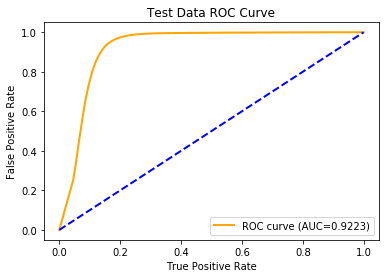

In [73]:
###################
#Standard ROC curve
###################

predicted = np.array(final_test_outputs)
truth = testing_dataset.y_data.numpy()
preds = np.array(final_test_preds)

#fpr, tpr, thresholds = sklm.roc_curve(truth,predicted,pos_label=1)
fpr, tpr, thresholds = sklm.roc_curve(truth,predicted)#,pos_label=1)
auc = sklm.roc_auc_score(truth,predicted)

print('AUC: {:.4f}'.format(auc))

#ROC curve
fig3 = plt.figure(3)
ax3 = fig3.add_subplot(111)

#plt.plot(fpr,tpr)
plt.plot(fpr,tpr,linewidth=2,linestyle='solid',color='orange',label="ROC curve (AUC={:.4f})".format(auc))
plt.plot(fpr,fpr,linewidth=2,linestyle='dashed',color='b')
plt.title('Test Data ROC Curve')

ax3.set_xlabel('True Positive Rate')
ax3.set_ylabel('False Positive Rate')

plt.legend(loc='lower right')
plt.legend()
plt.show()

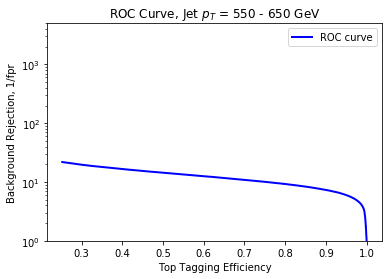

In [74]:
##############
#Log ROC curve
##############
background_rejection = safe_div(1,fpr)
#background_rejection = 1/fpr[2:] #the first and second elements of fpr are usually zero, so disregard these to avoid divide by zero

#ROC curve (using background rejection)
fig4 = plt.figure(4)
ax4 = fig4.add_subplot(111)

#plt.plot(fpr,tpr)
plt.semilogy(tpr[1:],background_rejection[1:],linewidth=2,linestyle='solid',color='blue',label="ROC curve")
plt.title('ROC Curve, Jet $p_T$ = 550 - 650 GeV')#,color='w')

ax4.set_xlabel('Top Tagging Efficiency')#, color='white')
ax4.set_ylabel('Background Rejection, 1/fpr')#, color='white')

plt.ylim(1, 5000)

plt.legend(loc='upper right')
plt.legend()
plt.show()

In [204]:
#####################
#Background Rejection
#####################
#looking at 20%, 50% and 80% signal efficiency
index_20,signal_efficiency_20 =find_nearest_ind(tpr,0.2)
index_50,signal_efficiency_50 =find_nearest_ind(tpr,0.5)
index_80,signal_efficiency_80 =find_nearest_ind(tpr,0.8)

#print('Background rejection at {:.1f}% signal efficiency: {:.3}\n'.format(signal_efficiency_20*100,background_rejection[index_20]))
#print('Background rejection at {:.1f}% signal efficiency: {:.3}\n'.format(signal_efficiency_50*100,background_rejection[index_50]))
#print('Background rejection at {:.1f}% signal efficiency: {:.3}\n'.format(signal_efficiency_80*100,background_rejection[index_80]))

from IPython.display import HTML, display
import tabulate
table = [["Signal Efficiency","Background Rejection"],
         ["{:.1f}".format(signal_efficiency_20*100),"{:.2f}".format(background_rejection[index_20])],
         ["{:.1f}".format(signal_efficiency_50*100),"{:.2f}".format(background_rejection[index_50])],
         ["{:.1f}".format(signal_efficiency_80*100),"{:.2f}".format(background_rejection[index_80])]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Signal Efficiency,Background Rejection
20.0,38.56
50.0,16.16
80.0,8.22


In [205]:
#####################
#Precsion, Recall, F1
#####################
precision = sklm.precision_score(truth,preds)
#print('Precision: {:.4f}'.format(precision))
recall = sklm.recall_score(truth,preds)
#print('Recall: {:.4f}'.format(recall))
f1 = sklm.f1_score(truth,preds)
#print('F1: {:.4f}'.format(f1))

from IPython.display import HTML, display
import tabulate
table = [["Precision","{:.3f}".format(precision)],
         ["Recall","{:.3f}".format(recall)],
         ["F1","{:.3f}".format(f1)]]
        
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Precision,0.873
Recall,0.95
F1,0.91


# Save the model and outputs

In [117]:
# ###########
# #Save model
# ###########
# torch.save(model.state_dict(),"preproDNN1.pt")

# ##Later to Restore
# #model.load_state_dict(torch.load(preproDNN1.pt))
# #model.eval()

# #################
# #Save fpr and tpr
# #################
# import pickle as pkl
# # f = open("fprtpr_preproDNN1","w")
# # pkl.dump(fpr,f)
# # pkl.dump(tpr,f)

# with open("fprtpr_preproDNN1.pkl","wb") as f:
#         pkl.dump((fpr,tpr),f)
 
# ##Later to Restore
# #with open("fprtpr_preproDNN1","rb") as f:
# #        fpr,tpr = pkl.load(f)


In [118]:
#Later to Restore
with open("fprtpr_preproDNN1.pkl","rb") as f:
        fpr,tpr = pkl.load(f)

In [119]:
print(len(fpr))

38995
